In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer





/Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Part-of-Speech Tagging 




Recall that the Brown Corpus has a list of all sentences tagged with parts of speech. The tags are
a bit odd, and not generally used any more, so we will use a much simpler set of tags the `universal_tagset`. 

If you run the following cells, you will see that there are 57,340 sentences, tagged with 12 different tags. 
 

In [2]:
import numpy as np
import nltk

# The first time you will need to download the corpus:

from nltk.corpus import brown
 
nltk.download('brown')
nltk.download('universal_tagset')

tagged_sentences = brown.tagged_sents(tagset='universal')

print(f'There are {len(tagged_sentences)} sentences tagged with universal POS tags in the Brown Corpus.')
print("\nHere is the first sentence with universal tags:",tagged_sentences[0])

[nltk_data] Downloading package brown to /Users/canerozer/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/canerozer/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


There are 57340 sentences tagged with universal POS tags in the Brown Corpus.

Here is the first sentence with universal tags: [('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


In [3]:
# Uncomment to see the complete list of tags. 

all_tagged_words = np.concatenate(tagged_sentences)
all_tags = sorted(set([pos for (w,pos) in all_tagged_words]))
print(f'There are {len(all_tags)} universal tags in the Brown Corpus.')
print(all_tags)
print()



There are 12 universal tags in the Brown Corpus.
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']



In [4]:
tagged_sentences=[sentence for sentence in tagged_sentences if len(sentence)<100]

In [5]:
len(tagged_sentences)

57300

### Baseline for the task, using the naive method

- Tagging every word with its most frequent POS tag (for example, if 'recent' is most frequently tagged as 'ADJ', then assume that every time 'recent' appears in a sentence, it should be tagged with 'ADJ'); 
- If a word has two or more most frequent tags, choosed the one that appears first in the list of sorted tags above. 

- Builded a dictionary mapping every word to its most frequent tag;
- Went through the entire tagged corpus, and report the accuracy (percentage of correct tags) of this baseline method. 


In [6]:
from collections import defaultdict

word_to_tag=dict()

for sentences in tagged_sentences:
    for pair in sentences:
        word=pair[0]
        if word not in word_to_tag:
        
            word_to_tag[word]=defaultdict(lambda : 0)
        

for sentences in tagged_sentences:
    for pair in sentences:
        word=pair[0]
        tag=pair[1]
        
        word_to_tag[word][tag] +=1
        
        




In [7]:
estimated_tagged_sentences=[]



for sentences in tagged_sentences:
    inner_array=[]
    for pair in sentences:
        
        word=pair[0]
        
        tags_key= list(word_to_tag[word].keys())
        tags_value= list(word_to_tag[word].values())
        
        tags_key_sorted= sorted(list(word_to_tag[word].keys()))
        tags_value_sorted= sorted(list(word_to_tag[word].values()))
        
        
        
        #most_key=tags_key[0]
        most_value=tags_value_sorted[-1]
        
        most_tags=[]
        for val in range(len(tags_value)):
            if tags_value[val]==most_value:
                most_tags +=[tags_key[val]]
            
        most_key= sorted(most_tags)[0]
        
        inner_array +=[(word, most_key)]
        
    
    estimated_tagged_sentences +=[inner_array]




In [8]:
num_total=0
num_correct=0

for sent in range(len(tagged_sentences)):
    for pair in range(len(tagged_sentences[sent])):
        num_total +=1
        
        if tagged_sentences[sent][pair][1]==estimated_tagged_sentences[sent][pair][1]:
            num_correct +=1
            

In [9]:
print(f"The accuracy of the baseline model is {num_correct/num_total}")

The accuracy of the baseline model is 0.957103855144329


### Viterbi Algorithm



In [10]:
def viterbi(obs_sequence, obs, states, start_p, trans_p, emit_p,logspace=True):
    
    V = [{}]
    for st in states:
        if logspace:
            V[0] [st] = {"prob": start_p[st] + emit_p[st][obs_sequence[0]], "prev": None}
        else:
            V[0] [st] = {"prob": start_p[st] * emit_p[st][obs_sequence[0]], "prev": None}
        
    # Run Viterbi when t > 0
    
    for t in range(1, len(obs_sequence)):
        V.append({})
        for st in states:
            
            if logspace:
                max_tr_prob = V[t - 1] [states[0]] ["prob"] + trans_p[states[0]] [st]
            else:
                max_tr_prob = V[t - 1] [states[0]] ["prob"] * trans_p[states[0]] [st]
                
            prev_st_selected = states[0]
            
            for prev_st in states[1:]:
                
                if logspace:
                    tr_prob = V[t - 1] [prev_st] ["prob"] + trans_p[prev_st] [st]
                else:
                    tr_prob = V[t - 1] [prev_st] ["prob"] * trans_p[prev_st] [st]
                    
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st

            if logspace:
                max_prob = max_tr_prob + emit_p[st] [obs_sequence[t]]
            else:
                max_prob = max_tr_prob * emit_p[st] [obs_sequence[t]]
                
            V[t] [st] = {"prob": max_prob, "prev": prev_st_selected}

    opt = []
    max_prob = float('-inf')
    best_st = None

    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_st = st
    opt.append(best_st)
    previous = best_st

    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1] [previous] ["prev"])
        previous = V[t + 1] [previous] ["prev"]

    return (opt,max_prob)



In [11]:
START_tag_prob_dict=defaultdict(int)


for sentence in tagged_sentences:
    tag=sentence[0][1]
    START_tag_prob_dict[tag] += 1
    
    
for key in START_tag_prob_dict:
    START_tag_prob_dict[key] /= len(tagged_sentences)
    
    

#to prevent underflow
START_tag_prob_dict_log=defaultdict(lambda: float('-inf'))


for key in START_tag_prob_dict:
    START_tag_prob_dict_log[key]= np.log(START_tag_prob_dict[key])



In [12]:
TRANS_probs= defaultdict(lambda: defaultdict(int))


for sentence in tagged_sentences:
    for pair in range(len(sentence)-1):
        
        tag=sentence[pair][1]
        next_tag=sentence[pair + 1][1]
        
        TRANS_probs[tag][next_tag] +=1 
        
        
        
for key in TRANS_probs:
    sum_prob=0
    for k in TRANS_probs[key]:
        sum_prob += TRANS_probs[key][k]
        
    for k1 in TRANS_probs[key]:
        TRANS_probs[key][k1] /= sum_prob
        
        
#again to avoid underflow

TRANS_probs_log=defaultdict(lambda: defaultdict(lambda: float('-inf')))

for key in TRANS_probs:
    for k in TRANS_probs[key]:
        TRANS_probs_log[key][k] = np.log(TRANS_probs[key][k1])
        
        



In [13]:
TRANS_probs

defaultdict(<function __main__.<lambda>()>,
            {'DET': defaultdict(int,
                         {'NOUN': 0.62668435946687,
                          'VERB': 0.06463248339467163,
                          'DET': 0.005916335537602088,
                          'ADJ': 0.23973988651192799,
                          'PRON': 0.009882553041744256,
                          'NUM': 0.00975792143810208,
                          'ADV': 0.017507074676324393,
                          'ADP': 0.009046788170261433,
                          '.': 0.012778405008724212,
                          'X': 0.0014002727232738522,
                          'PRT': 0.002008768199879767,
                          'CONJ': 0.0006451518306183194}),
             'NOUN': defaultdict(int,
                         {'NOUN': 0.14987679055857384,
                          'ADJ': 0.012931507249979891,
                          'VERB': 0.1595909592787312,
                          'DET': 0.015534626605927216,
     

In [14]:
EMIT_probs=defaultdict(lambda: defaultdict(int))


for sentence in tagged_sentences:
    for pair in sentence:
        word=pair[0]
        tag=pair[1]
        
        EMIT_probs[tag][word] +=1
        
for key in EMIT_probs:
    sum_prob = 0
    for k in EMIT_probs[key]:
        sum_prob += EMIT_probs[key][k]
        
    for k1 in EMIT_probs[key]:
        EMIT_probs[key][k1] /= sum_prob
        
#again to avoid underflow


EMIT_probs_log=defaultdict(lambda: defaultdict(lambda: float('-inf')))

for key in EMIT_probs:
    for k in EMIT_probs[key]:
        EMIT_probs_log[key][k]= np.log(EMIT_probs[key][k])




In [15]:
all_words=[]

for sentence in tagged_sentences:
    for pair in sentence:
        word=pair[0]
        
        all_words.append(word)
        

all_words=list(set(all_words))
        



In [16]:
len(all_words)

55863

In [17]:
import random
random.shuffle(tagged_sentences)

split_index = int(0.25 * len(tagged_sentences))

test_data = tagged_sentences[:split_index]

In [18]:
estimated_tagged_viterbi=[]


for sentence in tqdm(test_data):
    
    inner_array=[]
    
    words=[pair[0] for pair in sentence]
    
    estimated_tags,probs=viterbi(words, np.array(all_words), np.array(all_tags), START_tag_prob_dict, TRANS_probs, EMIT_probs,logspace=False)
    
    for i in range(len(words)):
        inner_array.append((words[i],estimated_tags[i]))
        
    estimated_tagged_viterbi += [inner_array]
    
    
    

100%|█████████████████████████████████████| 14325/14325 [06:50<00:00, 34.91it/s]


In [19]:
num_total1=0
num_correct1=0

for sent in range(len(test_data)):
    for pair in range(len(test_data[sent])):
        num_total1 +=1
        
        if test_data[sent][pair][1]==estimated_tagged_viterbi[sent][pair][1]:
            num_correct1 +=1
            

In [20]:
print(f"The accuracy for viterbi algorithm is {num_correct1/num_total1}")

The accuracy for viterbi algorithm is 0.9751557293930175


### LSTM Model



In [37]:
import random
random.shuffle(tagged_sentences)

split_index = int(0.3 * len(tagged_sentences))

tagged_sentences_train = tagged_sentences[:split_index]

#tagged_sentences_test=tagged_sentences[split_index:split_index*2]

In [38]:
all_tags_pad = ['PAD'] + all_tags 

In [39]:
all_words=[]

for sentence in tagged_sentences_train:
    for pair in sentence:
        word=pair[0]
        
        all_words.append(word)
        

all_words=list(set(all_words))
        
all_words = ['<pad>'] + all_words



In [40]:
vocabulary_dict=dict()

for i in range(len(all_words)):
    
    vocabulary_dict[all_words[i]]= i
    
    

In [41]:
vocabulary_size=len(vocabulary_dict)

In [42]:
tag_dict=dict()

for i in range(len(all_tags_pad)):
    
    tag_dict[all_tags_pad[i]]= i
    
    

In [43]:
train_words=[[pair[0] for pair in sent] for sent in tagged_sentences_train]
train_tags=[[pair[1] for pair in sent] for sent in tagged_sentences_train]

In [44]:
#padding 

padding_length=100

train_words_pad=[]
train_tags_pad=[]


for i in range(len(train_words)):
    
    num_pads=padding_length-len(train_words[i])
    pads=['<pad>']*num_pads
    pad_tags=['PAD']*num_pads
    
    train_words_pad +=[train_words[i] + pads] 
    train_tags_pad += [train_tags[i] + pad_tags] 




In [45]:
train_words_pad_encoded=[[vocabulary_dict[word] for word in sent] for sent in train_words_pad]

train_tags_pad_encoded=[[tag_dict[tag] for tag in sent] for sent in train_tags_pad]




In [46]:
split_index1 = int(0.75 * len(train_words_pad_encoded))

train_words_pad_encoded1 = train_words_pad_encoded[:split_index1]
train_tags_pad_encoded1 = train_tags_pad_encoded[:split_index1]

test_words_pad_encoded = train_words_pad_encoded[split_index1:]
test_tags_pad_encoded = train_tags_pad_encoded[split_index1:]

In [47]:
X=torch.tensor(train_words_pad_encoded1)
y=torch.tensor(train_tags_pad_encoded1)

TEST_X=torch.tensor(test_words_pad_encoded)
TEST_y=torch.tensor(test_tags_pad_encoded)



In [48]:
class DataSet_POS(Dataset):
    
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
        
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
ds=DataSet_POS(X, y)
        

In [49]:
batch_size = 128

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [50]:
embedding_dimension=200

weights_matrix= np.zeros((vocabulary_size, embedding_dimension))

with open("/Users/canerozer/Desktop/HW05/glove.6B/glove.6B.200d.txt", 'r', encoding='utf-8') as f: 
    
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:], "float32")
        if word in vocabulary_dict:
            index = vocabulary_dict[word]
            weights_matrix[index]= vector
            
            
weights_matrix=torch.tensor(weights_matrix, dtype=torch.float)



In [51]:
class LSTM_Model_POS(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, embedding_weights, hidden_dim, tag_len):
        super(LSTM_Model_POS, self).__init__()
    
        self.vocabulary_size=vocabulary_size
        self.embedding_size=embedding_size
        self.embedding_weights=embedding_weights
        self.hidden_dim=hidden_dim
        self.tag_len= tag_len
        
        
        self.embedding= nn.Embedding(self.vocabulary_size, self.embedding_size)
        self.embedding.weight=nn.Parameter(self.embedding_weights)
        self.embedding.weight.requires_grad=True # for fine-tuning 
        
        #LSTM layer
        self.lstm= nn.LSTM(self.embedding_size, self.hidden_dim, batch_first=True)
        
    
        self.fc= nn.Linear(self.hidden_dim, self.tag_len)
        
        
    def forward(self, x):
        
        
        x=self.embedding(x)
        
        lstm_output,_ = self.lstm(x)
        
        lstm_output=lstm_output.contiguous().view(-1, lstm_output.shape[2])
        
        out=self.fc(lstm_output)
        
        out=out.view(x.size(0), -1, self.tag_len)
        
        return out
        
        
        



In [68]:
class BiLSTM_Model_POS(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, embedding_weights, hidden_dim, tag_len):
        super(BiLSTM_Model_POS, self).__init__()
    
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.embedding_weights = embedding_weights
        self.hidden_dim = hidden_dim
        self.tag_len = tag_len
        
        self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
        self.embedding.weight = nn.Parameter(self.embedding_weights)
        self.embedding.weight.requires_grad = True  # for fine-tuning 
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_dim, batch_first=True, bidirectional=True)
    
        # Adjusted linear layer input dimension
        self.fc = nn.Linear(self.hidden_dim * 2, self.tag_len)
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_output, _ = self.lstm(x)
        lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim * 2)
        out = self.fc(lstm_output)
        out = out.view(x.size(0), -1, self.tag_len)
        return out
        
        

In [76]:
class TwoLayerLSTM_Model_POS(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, embedding_weights, hidden_dim, tag_len):
        super(TwoLayerLSTM_Model_POS, self).__init__()
    
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.embedding_weights = embedding_weights
        self.hidden_dim = hidden_dim
        self.tag_len = tag_len
        
        self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
        self.embedding.weight = nn.Parameter(self.embedding_weights)
        self.embedding.weight.requires_grad = True  # for fine-tuning 
        
        # Two-layer LSTM
        self.lstm1 = nn.LSTM(self.embedding_size, self.hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim, batch_first=True)
    
        # Output linear layer
        self.fc = nn.Linear(self.hidden_dim, self.tag_len)
        
    def forward(self, x):
        x = self.embedding(x)
        
        # First LSTM layer
        lstm_output1, _ = self.lstm1(x)
        
        # Second LSTM layer
        lstm_output2, _ = self.lstm2(lstm_output1)
        
        lstm_output = lstm_output2.contiguous().view(-1, lstm_output2.shape[2])
        out = self.fc(lstm_output)
        out = out.view(x.size(0), -1, self.tag_len)
        
        return out

In [53]:
hidden_dimension=256
tag_len=len(tag_dict)

model_pos= LSTM_Model_POS(vocabulary_size, embedding_dimension, weights_matrix, hidden_dimension, tag_len)



In [54]:
num_epochs=10

optimizer=torch.optim.Adam(model_pos.parameters(), lr=0.001, weight_decay=0.0)

loss_fn=nn.CrossEntropyLoss()

losses=[]

for epoch in tqdm(range(num_epochs)):
    
    model_pos.train()
    
    for X_train_batch, y_train_batch in data_loader:
        
        optimizer.zero_grad()
        
        y_train_hat= model_pos(X_train_batch)
        
        loss=loss_fn(y_train_hat.view(-1, tag_len), y_train_batch.view(-1))
        loss.backward()
        optimizer.step()
  

    losses.append(loss.item())




100%|███████████████████████████████████████████| 10/10 [10:58<00:00, 65.89s/it]


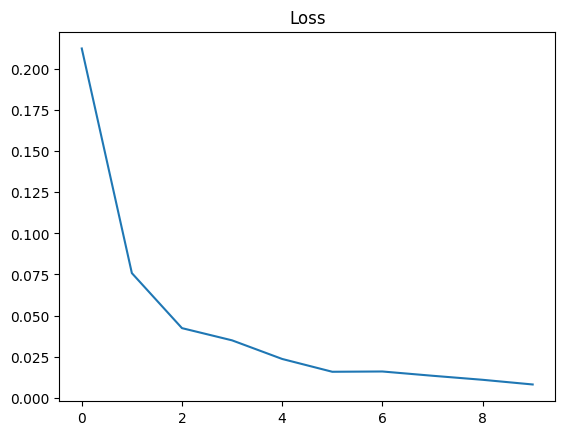

In [55]:
plt.title('Loss')
plt.plot(losses)

In [56]:
TEST=model_pos(TEST_X)

In [57]:
TEST_estimated_tags=[]

for t in TEST:
    
    TEST_estimated_tags+=[torch.argmax(t, dim=1)]

In [58]:
num_total2=0
num_correct2=0

for x in range(len(TEST_estimated_tags)):
    for y in range(len(TEST_estimated_tags[x])):
        num_total2 +=1
        
        if TEST_y[x][y].item()==TEST_estimated_tags[x][y].item():
            num_correct2 +=1

In [59]:
print(f"The accuracy of the LSTM model is {num_correct2/num_total2}")

The accuracy of the LSTM model is 0.9899744067007911


In [69]:
model_pos1= BiLSTM_Model_POS(vocabulary_size, embedding_dimension, weights_matrix, hidden_dimension, tag_len)



In [70]:
num_epochs=10

optimizer=torch.optim.Adam(model_pos1.parameters(), lr=0.001, weight_decay=0.0)

loss_fn=nn.CrossEntropyLoss()

losses1=[]

for epoch in tqdm(range(num_epochs)):
    
    model_pos1.train()
    
    for X_train_batch, y_train_batch in data_loader:
        
        optimizer.zero_grad()
        
        y_train_hat= model_pos1(X_train_batch)
        
        #loss=loss_fn(y_train_hat.view(-1, tag_len), y_train_batch.view(-1))
        loss = loss_fn(y_train_hat.view(-1, tag_len), y_train_batch.view(-1))
        loss.backward()
        optimizer.step()
  

    losses1.append(loss.item())

100%|██████████████████████████████████████████| 10/10 [21:53<00:00, 131.36s/it]


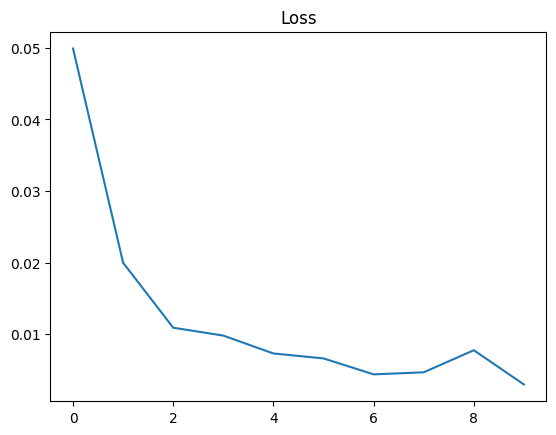

In [71]:
plt.title('Loss')
plt.plot(losses1)

In [72]:
TEST1=model_pos1(TEST_X)

In [73]:
TEST1_estimated_tags=[]

for t in TEST1:
    
    TEST1_estimated_tags+=[torch.argmax(t, dim=1)]

In [74]:
num_total3=0
num_correct3=0

for x in range(len(TEST1_estimated_tags)):
    for y in range(len(TEST1_estimated_tags[x])):
        num_total3 +=1
        
        if TEST_y[x][y].item()==TEST1_estimated_tags[x][y].item():
            num_correct3 +=1

In [75]:
print(f"The accuracy of the Bidirectional LSTM model is {num_correct3/num_total3}")

The accuracy of the Bidirectional LSTM model is 0.9927710563052583


In [77]:
model_pos2= TwoLayerLSTM_Model_POS(vocabulary_size, embedding_dimension, weights_matrix, hidden_dimension, tag_len)

In [78]:
num_epochs=10

optimizer=torch.optim.Adam(model_pos2.parameters(), lr=0.001, weight_decay=0.0)

loss_fn=nn.CrossEntropyLoss()

losses2=[]

for epoch in tqdm(range(num_epochs)):
    
    model_pos2.train()
    
    for X_train_batch, y_train_batch in data_loader:
        
        optimizer.zero_grad()
        
        y_train_hat= model_pos2(X_train_batch)
        
        loss = loss_fn(y_train_hat.view(-1, tag_len), y_train_batch.view(-1))
        loss.backward()
        optimizer.step()
  

    losses2.append(loss.item())

100%|██████████████████████████████████████████| 10/10 [21:38<00:00, 129.81s/it]


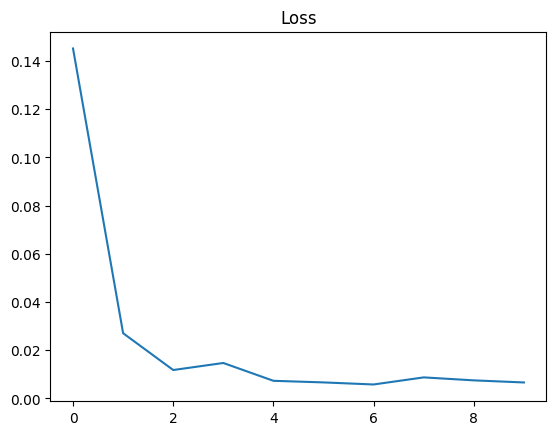

In [79]:
plt.title('Loss')
plt.plot(losses2)

In [80]:
TEST2=model_pos2(TEST_X)

In [81]:
TEST2_estimated_tags=[]

for t in TEST2:
    
    TEST2_estimated_tags+=[torch.argmax(t, dim=1)]

In [82]:
num_total4=0
num_correct4=0

for x in range(len(TEST2_estimated_tags)):
    for y in range(len(TEST2_estimated_tags[x])):
        num_total4 +=1
        
        if TEST_y[x][y].item()==TEST2_estimated_tags[x][y].item():
            num_correct4 +=1

In [83]:
print(f"The accuracy of the Bidirectional LSTM model is {num_correct4/num_total4}")

The accuracy of the Bidirectional LSTM model is 0.9882270823638902


### Anlaysis

With no choice of hyperparameters (not using bidirectional and using only one layer), the accuracy was 0.98997. With using bidirectional lstm model, the accuracy was 0.99277. And with using two layers unidirectional model, the accuracy was 0.988227. The best accuracy is yielded with bidirectional model.

For unidirectional models, since the accuracies are both so high it would not be accuracte to say the number of layers don't have any impact. But from my experiments I can say that using bidirectional model makes more difference in the predictions.

The flexibility of choice was helpful since I increased the accuracy level by just changing parameters. Like changing bidirectional=True parameter and adjusting the sizes of the inputs...